## Xgboost 模型搭建

### 0. packages

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline
from pyhive import hive
import os
import time
import random
import math as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve, auc 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Imputer
from sklearn.ensemble import  VotingClassifier
from sklearn2pmml import PMMLPipeline

from sklearn.cluster import FeatureAgglomeration
from sklearn import preprocessing

from lightgbm.sklearn import LGBMClassifier


#import pyWoE
#import LR

plt.style.use('ggplot')
pd.set_option('display.width',500)
pd.set_option('display.max_columns',350)
pd.set_option('display.max_rows',250)

OutputPath='/home/jovyan/multi_loan/Multiloan/'

### 1. load data

In [2]:
import findspark
findspark.init("/opt/spark")

import pandas as pd
import numpy as np
import os
from nxmodel import dstool
config = {
"spark.pyspark.driver.python":"/root/anaconda3/envs/python2.7/bin/python2.7",
"spark.pyspark.python":"/usr/local/python/bin/python2.7",
"spark.executor.memory": "16g",
"spark.dynamicAllocation.maxExecutors": "50",
"spark.dynamicAllocation.minExecutors": "10",
"spark.executorEnv.JAVA_HOME": "/usr/java/jdk1.8.0_74",
"spark.executor.cores": "1",
"spark.executorEnv.HADOOP_HOME":"/opt/cloudera/parcels/CDH/lib/hadoop",
"spark.executorEnv.HADOOP_COMMON_LIB_NATIVE_DIR":"/opt/cloudera/parcels/CDH/lib/hadoop/lib/native",
"spark.executorEnv.HADOOP_OPTS":"-Djava.library.path=/opt/cloudera/parcels/CDH/lib/hadoop/lib/native",
"spark.yarn.queue": "root.ds_prod_etl.default"
}

In [4]:
from pyhive import hive
import pandas as pd
# conn = hive.Connection(host='', port=10000, username='', password', database='vdm_ds_dev', auth='LDAP')
# raw_data = pd.read_sql("select t.* from table t", conn)

# #修改Column名称
# raw_data.columns = raw_data.columns.str[2:]
# raw_data['apply_date'] = raw_data.apply_time.str[:10]
# raw_data['apply_month'] = raw_data.apply_time.str[:7]

rawdata_path = '/home/jovyan/multi_loan/Multiloan/%s_%s_%s_data.csv' % ('2017-12-10', '2018-05-31', 'MultiloanV1')
if os.path.exists(rawdata_path):
    raw_data = pd.read_csv(rawdata_path, encoding='utf-8')
else:
    conn = hive.Connection(host='', port=10000, username='', password='', database='vdm_ds_dev', auth='LDAP')
    raw_data = pd.read_sql("select t.* from table t", conn)
    raw_data.columns = raw_data.columns.str[2:]
    raw_data['apply_date'] = raw_data.apply_time.str[:10]
    raw_data['apply_month'] = raw_data.apply_time.str[:7]
    print('已经保存在：' + rawdata_path)


已经保存在：/home/jovyan/multi_loan/Multiloan/2017-12-10_2018-05-31_MultiloanV1_data.csv


### 2. 数据探查与清洗

#### 2.1 缺失值情况统计

In [5]:
import pandas as pd
import math

def VIM(data):
    """
    该函数用来实现特征缺失情况的统计
    :param data: 输入的dataframe
    :return: 缺失情况统计
    """
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() * 1.0 / data.isnull().count() * 100).sort_values(ascending = False)

    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent(%)'])

#### 2.2  EDA 特征描述性统计

In [6]:
def EDA_Calculate(InputDf,GroupVar,GroupValue,Cols):
    """
    本函数用来计算输入数据的描述性统计情况EDA
    
    :param InputDf: 输入的dataframe
    :param GroupVar: 分组依据，如按组(INS/OOS/OOT),or按月、周。
    :param GroupValue: 分组元素取值
    :param Cols: 特征列表
    :return: 分组每个变量的分布情况，即分位数
    """
    Output=pd.DataFrame()
    for Group_i in set(GroupValue): # set函数创建一个无序不重复的元素集
        OutputPre = pd.DataFrame()
        OutputPre = pd.DataFrame(InputDf[InputDf[GroupVar]==Group_i][Cols].describe().T,)
        OutputPre.loc[:,'TotalCount'] = InputDf[InputDf[GroupVar]==Group_i][Cols].fillna(0).count()
        OutputPre.loc[:,'MissingRate'] = 1 - InputDf[InputDf[GroupVar]==Group_i][Cols].count()/InputDf[InputDf[GroupVar]==Group_i][Cols].fillna(0).count()
        OutputPre.loc[:,GroupVar] = Group_i
        Output=pd.concat([Output,OutputPre],axis=0)
    return Output

In [7]:
# 定义GroupVar
date1 = '2017-12-10'
date2 = '2018-03-01'
date3 = '2018-04-01'
date4 = '2018-01-01'

label_0 = 'label'

def row_grouping(row):
    if (row['apply_date'] >= date4 and row['apply_date'] < date2)  and row['RandNum'] <= 0.7:
        return 'INS'  # 70%训练集
    elif (row['apply_date'] >= date1 and row['apply_date'] < date2) and row['RandNum'] > 0.7:
        return 'OOS'  # 30%验证集
    elif row['apply_date'] >= date2 and row['apply_date'] < date3:
        return 'OOT1'  # OOT1
    elif row['apply_date'] >= date1 and row['apply_date'] < date4:
        return 'OOT2'  # OOT2
    else:
        return 'NA'


In [8]:
raw_data.loc[:, 'RandNum'] = [random.random() for i in range(len(raw_data))]
raw_data.loc[:, 'Group'] = raw_data.apply(row_grouping, axis=1)

In [9]:
# 定义cols
all_cols = list(raw_data.columns)
except_cols = ['order_original_id', 'apply_time', 'user_id', 'order_id','id','is_loaned','overdue_1'
               ,'overdue_2','overdue_3','overdue_max','apply_month','apply_date', 'RandNum', 'Group']
model_features = [x for x in set(all_cols) if x not in set(except_cols)]

In [10]:
GroupVar = 'apply_month'
GroupValue = ['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']
Cols = model_features
EDA_df = EDA_Calculate(raw_data,GroupVar,GroupValue,Cols)

# EDA_df.to_csv(OutputPath+'Multiloan_xgb_EDA.csv')

#### 2.3 缺失值处理

In [11]:
# 删除缺失率高，设备相关解释性差，网贷中介相关的特征, 与target高度相关的特征
delete_cols = ['carrier_call_financial_agent_l3m','carrier_p2p_call_in_ratio_l6m_vs_l12m','carrier_call_financial_agent_l1m',
               'carrier_financial_agent_call_time_l6m','carrier_s90_agent_mobile_ratio_l3m_vs_l12m','carrier_s120_agent_mobile_ratio_l3m_vs_l12m',
               'carrier_p2p_call_in_ratio_l3m_vs_l12m','carrier_call_financial_agent_afternoon_count_l6m','carrier_p2p_mobile_ratio_l3m_vs_l12m',
               'contacts_financial_agent_ratio_cp','carrier_financial_agent_call_time_l1m','carrier_call_financial_agent_l12m',
               'carrier_p2p_mobile_ratio_l6m_vs_l12m','carrier_p2p_mobile_ratio_l1m_vs_l12m','carrier_financial_agent_call_time_l12m',
               'carrier_s250_agent_mobile_ratio_l3m_vs_l12m','carrier_call_out_financial_agent_l6m','carrier_call_financial_agent_l6m',
               'carrier_call_financial_agent_afternoon_count_l1m','carrier_call_financial_agent_afternoon_count_l3m',
               'carrier_s140_agent_mobile_ratio_l3m_vs_l12m','carrier_financial_agent_call_time_l3m','carrier_call_financial_agent_afternoon_count_l12m',
               'carrier_call_out_financial_agent_l12m','carrier_call_out_financial_agent_l1m','carrier_call_out_financial_agent_l3m','device_app_name_num_90',
               'device_app_title_num_90','device_bd_umid_num_90','device_bssid_num_90','device_carrier_num_90','device_fingerprint_num_90','device_free_size_sd_max_90',
               'device_free_size_sd_min_90','device_free_size_sd_std_90','device_rom_std_90','device_sim_state_num_90','device_ssid_num_90','device_idfv_num_90',
               'device_clipboard_num_90','device_is_has_clipboard_90','device_is_core_time_error_90','device_core_time_num_90','device_average_brightness_90',
               'device_rom_max_90','device_rom_avg_90','device_version_num_90','device_ram_max_90','device_channel_num_90','device_ram_avg_90','device_free_size_min_90',
               'device_rom_min_90','device_ram_min_90','device_device_key_num_90','device_big_app_id_num_90','device_build_time_num_90','device_app_id_num_90',
               'device_free_size_std_90','device_free_size_max_90','device_ram_std_90','device_boot_time_num_90','device_dns_num_90','device_build_time_boot_time_diff_max_90',
               'device_build_time_boot_time_diff_min_90','device_ram_size','device_rom_free_size','device_sd_size','device_sd_free_size','device_resolution','device_plat',
               'device_app_no','device_applist','device_rom_size','device_rom_rate','device_app_phone_use_time_ratio','device_phone_use_time','this_loan_num','this_loan_ratio',
               'this_cash_num','this_cash_ratio','this_back_num','this_back_ratio','this_robbing_num','this_robbing_ratio','this_0to1m_loan_num','this_0to1m_cash_num',
               'this_0to1m_back_num','this_0to1m_robbing_num','this_0to2m_loan_num','this_0to2m_cash_num','this_0to2m_back_num','this_0to2m_robbing_num','this_0to3m_loan_num',
               'this_0to3m_cash_num','this_0to3m_back_num','this_0to3m_robbing_num','label_1','label_2','label_0','is_multiloan','is_s1d30','is_s3d15']
final_cols = [x for x in set(model_features) if x not in set(delete_cols)]

In [12]:
# 删除线上特征
cols = ['app_platform_num_1m_avg','app_platform_num_3m_avg','app_platform_num_6m_avg','app_platform_num_12m_avg',
        'app_platform_num_18m_avg','app_platform_num_7d1m','app_platform_num_7d3m','app_platform_num_1m3m',
        'app_platform_num_7d6m','app_platform_num_1m6m','app_platform_num_3m6m','app_platform_num_7d12m',
        'app_platform_num_1m12m','app_platform_num_3m12m','app_platform_num_6m12m','app_platform_num_7d18m',
        'app_platform_num_1m18m','app_platform_num_3m18m','app_platform_num_6m18m','app_platform_num_12m18m',
        'app_platform_num_7d24m','app_platform_num_1m24m','app_platform_num_3m24m','app_platform_num_6m24m',
        'app_platform_num_12m24m','app_platform_num_18m24m','app_consbank_num_1m_avg','app_consbank_num_3m_avg',
        'app_consbank_num_6m_avg','app_consbank_num_12m_avg','app_consbank_num_18m_avg','app_consbank_num_7d1m',
        'app_consbank_num_7d3m','app_consbank_num_1m3m','app_consbank_num_7d6m','app_consbank_num_1m6m',
        'app_consbank_num_3m6m','app_consbank_num_7d12m','app_consbank_num_1m12m','app_consbank_num_3m12m',
        'app_consbank_num_6m12m','app_consbank_num_7d18m','app_consbank_num_1m18m','app_consbank_num_3m18m',
        'app_consbank_num_6m18m','app_consbank_num_12m18m','app_consbank_num_7d24m','app_consbank_num_1m24m',
        'app_consbank_num_3m24m','app_consbank_num_6m24m','app_consbank_num_12m24m','app_consbank_num_18m24m',
        'app_consfina_num_1m_avg','app_consfina_num_3m_avg','app_consfina_num_6m_avg','app_consfina_num_12m_avg',
        'app_consfina_num_18m_avg','app_consfina_num_7d1m','app_consfina_num_7d3m','app_consfina_num_1m3m',
        'app_consfina_num_7d6m','app_consfina_num_1m6m','app_consfina_num_3m6m','app_consfina_num_7d12m',
        'app_consfina_num_1m12m','app_consfina_num_3m12m','app_consfina_num_6m12m','app_consfina_num_7d18m',
        'app_consfina_num_1m18m','app_consfina_num_3m18m','app_consfina_num_6m18m','app_consfina_num_12m18m',
        'app_consfina_num_7d24m','app_consfina_num_1m24m','app_consfina_num_3m24m','app_consfina_num_6m24m',
        'app_consfina_num_12m24m','app_consfina_num_18m24m','app_consinst_num_1m_avg','app_consinst_num_3m_avg',
        'app_consinst_num_6m_avg','app_consinst_num_12m_avg','app_consinst_num_18m_avg','app_consinst_num_7d1m',
        'app_consinst_num_7d3m','app_consinst_num_1m3m','app_consinst_num_7d6m','app_consinst_num_1m6m',
        'app_consinst_num_3m6m','app_consinst_num_7d12m','app_consinst_num_1m12m','app_consinst_num_3m12m',
        'app_consinst_num_6m12m','app_consinst_num_7d18m','app_consinst_num_1m18m','app_consinst_num_3m18m',
        'app_consinst_num_6m18m','app_consinst_num_12m18m','app_consinst_num_7d24m','app_consinst_num_1m24m',
        'app_consinst_num_3m24m','app_consinst_num_6m24m','app_consinst_num_12m24m','app_consinst_num_18m24m',
        'app_pettloan_num_1m_avg','app_pettloan_num_3m_avg','app_pettloan_num_6m_avg','app_pettloan_num_12m_avg',
        'app_pettloan_num_18m_avg','app_pettloan_num_7d1m','app_pettloan_num_7d3m','app_pettloan_num_1m3m',
        'app_pettloan_num_7d6m','app_pettloan_num_1m6m','app_pettloan_num_3m6m','app_pettloan_num_7d12m',
        'app_pettloan_num_1m12m','app_pettloan_num_3m12m','app_pettloan_num_6m12m','app_pettloan_num_7d18m',
        'app_pettloan_num_1m18m','app_pettloan_num_3m18m','app_pettloan_num_6m18m','app_pettloan_num_12m18m',
        'app_pettloan_num_7d24m','app_pettloan_num_1m24m','app_pettloan_num_3m24m','app_pettloan_num_6m24m',
        'app_pettloan_num_12m24m','app_pettloan_num_18m24m','app_p2p_num_1m_avg','app_p2p_num_3m_avg',
        'app_p2p_num_6m_avg','app_p2p_num_12m_avg','app_p2p_num_18m_avg','app_p2p_num_7d1m','app_p2p_num_7d3m',
        'app_p2p_num_1m3m','app_p2p_num_7d6m','app_p2p_num_1m6m','app_p2p_num_3m6m','app_p2p_num_7d12m',
        'app_p2p_num_1m12m','app_p2p_num_3m12m','app_p2p_num_6m12m','app_p2p_num_7d18m','app_p2p_num_1m18m',
        'app_p2p_num_3m18m','app_p2p_num_6m18m','app_p2p_num_12m18m','app_p2p_num_7d24m','app_p2p_num_1m24m',
        'app_p2p_num_3m24m','app_p2p_num_6m24m','app_p2p_num_12m24m','app_p2p_num_18m24m','app_platform_num_1m_ratio','app_platform_num_3m_ratio','app_platform_num_6m_ratio','app_platform_num_12m_ratio','app_platform_num_18m_ratio','app_consbank_num_1m_ratio','app_consbank_num_3m_ratio','app_consbank_num_6m_ratio','app_consbank_num_12m_ratio','app_consbank_num_18m_ratio','app_consinst_num_1m_ratio','app_consinst_num_3m_ratio','app_consinst_num_6m_ratio','app_consinst_num_12m_ratio','app_consinst_num_18m_ratio','app_consfina_num_1m_ratio','app_consfina_num_3m_ratio','app_consfina_num_6m_ratio','app_consfina_num_12m_ratio','app_consfina_num_18m_ratio','app_pettloan_num_1m_ratio','app_pettloan_num_3m_ratio','app_pettloan_num_6m_ratio','app_pettloan_num_12m_ratio','app_pettloan_num_18m_ratio','app_p2p_num_1m_ratio','app_p2p_num_3m_ratio','app_p2p_num_6m_ratio','app_p2p_num_12m_ratio','app_p2p_num_18m_ratio']

sel_cols = ['app_consbank_num_1m24m','app_consbank_num_3m18m','app_consbank_num_3m24m','app_consbank_num_6m18m','app_consbank_num_12m24m','app_consfina_num_3m18m','app_consfina_num_6m12m','app_consfina_num_3m_ratio','app_p2p_num_7d1m','app_p2p_num_7d3m','app_p2p_num_7d6m','app_p2p_num_7d12m','app_p2p_num_7d18m','app_p2p_num_1m6m','app_p2p_num_1m12m','app_p2p_num_1m24m','app_p2p_num_3m12m','app_p2p_num_6m12m','app_p2p_num_12m18m','app_p2p_num_1m_avg','app_p2p_num_3m_ratio','app_pettloan_num_3m12m','app_pettloan_num_3m18m','app_pettloan_num_3m24m','app_pettloan_num_6m24m','app_pettloan_num_12m18m','app_pettloan_num_1m_ratio','app_platform_num_7d3m','app_platform_num_7d12m','app_platform_num_7d24m','app_platform_num_1m6m','app_platform_num_1m12m','app_platform_num_1m18m','app_platform_num_1m24m','app_platform_num_3m6m','app_platform_num_3m12m','app_platform_num_3m18m','app_platform_num_3m24m','app_platform_num_6m12m','app_platform_num_6m18m','app_platform_num_12m18m','app_platform_num_1m_avg','app_platform_num_3m_avg','app_platform_num_6m_avg','app_platform_num_1m_ratio','app_platform_num_3m_ratio','app_platform_num_6m_ratio','app_platform_num_12m_ratio','app_platform_num_18m_ratio']
det_cols = [x for x in set(cols) if x not in set(sel_cols)]

In [13]:
final_cols = [x for x in set(final_cols) if x not in set(det_cols)]

In [11]:
selected_cols = ['app_platform_num_6m18m','app_platform_num_3m','app_platform_num_12m18m','app_platform_num_1m',
                 'app_platform_num_7d24m','app_platform_num_7d','app_platform_num_3m24m','app_platform_num_6m',
                 'app_platform_num_12m','app_p2p_num_1m','app_platform_num_18m_ratio','app_p2p_num_6m12m',
                 'app_platform_num_6m12m','app_p2p_num_12m18m','app_platform_num_7d12m','app_platform_num_1m_ratio',
                 'app_platform_num_6m_ratio','app_platform_num_3m_ratio','app_p2p_num_6m',
                 'app_p2p_num_12m','app_p2p_num_1m24m','app_platform_num_18m','app_p2p_num_18m','app_consinst_num_7d',
                 'app_consinst_num_3m','app_platform_num_12m_ratio','app_p2p_num_3m','app_platform_num_3m18m',
                 'app_p2p_num_24m','app_p2p_num_3m_ratio','app_platform_num_1m12m',
                 'app_consinst_num_1m','app_p2p_num_7d12m','app_consinst_num_24m','app_platform_num_3m12m',
                 'app_platform_num_24m','app_platform_num_1m6m','app_platform_num_7d3m',
                 'app_platform_num_3m6m','app_platform_num_1m24m','app_p2p_num_3m12m','app_consfina_num_12m',
                 'app_consbank_num_6m18m','app_consfina_num_3m_ratio','app_consfina_num_3m18m','app_consfina_num_6m12m',
                 'app_pettloan_num_3m18m','app_p2p_num_1m6m','app_platform_num_6m_avg','app_pettloan_num_12m18m',
                 'app_platform_num_1m18m','app_p2p_num_7d18m']

### 3. Model

#### 3.1 数据集/时间窗口

In [12]:
# 定义训练集INS
raw_data_full = raw_data.copy()
raw_data = raw_data_full.loc[raw_data_full['label_0'].isin([0,1]),:]
raw_data_ins = raw_data[raw_data['Group'] == 'INS']

In [13]:
# 创建用来进行训练模型的数据
X_ins = pd.DataFrame(raw_data_ins[selected_cols],dtype=np.float)
Y_ins = raw_data_ins[['label_0']]

#### 3.2 训练模型

In [14]:
X=X_ins.values
Y=Y_ins.values.reshape(Y_ins.values.shape[0],).astype('float64').astype(np.int64)

def XGB_CV(X,y):
    param_test = {
        'max_depth': range(5,10,2),
        'n_estimators': range(50,100,10),
    }
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=80,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        reg_alpha=2,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
    gsearch = GridSearchCV( estimator , param_grid = param_test, scoring='roc_auc', cv=3)
    gsearch.fit(X, y)
    gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    
    # 输出best score
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    # 输出最佳的分类器到底使用了怎样的参数
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

XGB_CV(X,Y)

Best score: 0.721
Best parameters set:
	max_depth: 5
	n_estimators: 50


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [24]:
X=X_ins.values
Y=Y_ins.values.reshape(Y_ins.values.shape[0],).astype('float64').astype(np.int64)

def XGB_CV(X,y):
    param_test = {
        'max_depth': range(5,10,2),
        'n_estimators': range(50,100,10),
    }
    estimator = XGBClassifier(
        learning_rate =0.05,
        n_estimators=100,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        reg_alpha=10,
        reg_lamda=1,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=1,
        scale_pos_weight=1,
        seed=27)
    gsearch = GridSearchCV( estimator , param_grid = param_test, scoring='roc_auc', cv=3)
    gsearch.fit(X, y)
    gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    
    # 输出best score
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    # 输出最佳的分类器到底使用了怎样的参数
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

XGB_CV(X,Y)

Best score: 0.723
Best parameters set:
	max_depth: 5
	n_estimators: 90


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### 3.3 模型调优

In [15]:
# 样本赋权
xgb = XGBClassifier(
        learning_rate =0.05,
        n_estimators=100,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        reg_alpha=10,
        reg_lamda=1,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=1,
        scale_pos_weight=1,
        seed=27)
w = np.where(raw_data_ins['is_s3d15']==1, 3, 1)
xgb = xgb.fit(X,Y,sample_weight=w)
# xgb = xgb.fit(X,Y)

In [18]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=20,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        reg_alpha=1,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
w = np.where(raw_data_ins['is_s3d15']==1, 3, 1)
xgb1 = xgb1.fit(X,Y,sample_weight=w)

#### 3.4 特征重要性

app_platform_num_1m           0.079646
app_platform_num_3m           0.058997
app_platform_num_12m18m       0.057522
app_platform_num_6m           0.056047
app_platform_num_6m18m        0.039823
app_platform_num_7d24m        0.036873
app_platform_num_6m12m        0.033923
app_p2p_num_1m                0.032448
app_p2p_num_12m18m            0.032448
app_platform_num_7d           0.030973
app_platform_num_3m24m        0.028024
app_platform_num_12m          0.025074
app_p2p_num_12m               0.023599
app_p2p_num_7d18m             0.023599
app_consinst_num_1m           0.022124
app_platform_num_3m12m        0.020649
app_platform_num_3m18m        0.019174
app_platform_num_6m_ratio     0.019174
app_p2p_num_18m               0.019174
app_p2p_num_6m                0.017699
app_consfina_num_3m_ratio     0.017699
app_platform_num_7d12m        0.016224
app_platform_num_3m_ratio     0.016224
app_p2p_num_1m24m             0.014749
app_platform_num_12m_ratio    0.014749
app_consfina_num_12m     

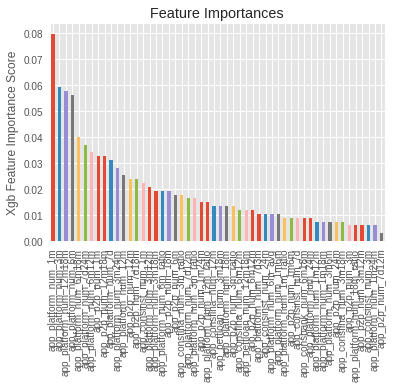

In [17]:
xgb_feat_imp = pd.Series(xgb.feature_importances_,selected_cols).sort_values(ascending=False)[0:100]
xgb_feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Xgb Feature Importance Score')
print(xgb_feat_imp)
pd.Series(xgb.feature_importances_,selected_cols).sort_values(ascending=False).to_csv(OutputPath+'Feature_importance_xgb.csv')

#### 3.5 模型效果评估

In [18]:
# 评估指标为KS，PSI
def psi(expected_array, actual_array, buckets=10, buckettype='bins'):
    '''Calculate the PSI for a single variable 
    
    Args:
       expected_array: numpy array of original values
       actual_array: numpy array of new values, same size as expected
       buckets: number of percentile ranges to bucket the values into
       
    Returns:
       psi_value: calculated PSI value
    '''
        
    def scale_range (input, min, max):
        input += -(np.min(input))
        if max - min != 0:
            input /= np.max(input) / (max - min)
        input += min
        return input
    
    
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    
    if buckettype == 'bins':
        breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
    elif buckettype == 'quantiles':
        breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])
    
    def generate_counts(arr, breakpoints):
        '''Generates counts for each bucket by using the bucket values 
        
        Args:
           arr: ndarray of actual values
           breakpoints: list of bucket values
        
        Returns:
           counts: counts for elements in each bucket, length of breakpoints array minus one
        '''
    
        def count_in_range(arr, low, high, start):
            '''Counts elements in array between low and high values.
               Includes value if start is true
            '''
            if start:
                return(len(np.where(np.logical_and(arr>=low, arr<=high))[0]))
            return(len(np.where(np.logical_and(arr>low, arr<=high))[0]))
    
        
        counts = np.zeros(len(breakpoints)-1)
    
        for i in range(1, len(breakpoints)):
            counts[i-1] = count_in_range(arr, breakpoints[i-1], breakpoints[i], i==1)
    
        return(counts)
    
    
    expected_percents = generate_counts(expected_array, breakpoints) / len(expected_array)
    actual_percents = generate_counts(actual_array, breakpoints) / len(actual_array)
    
    def sub_psi(e_perc, a_perc):
        '''Calculate the actual PSI value from comparing the values.
           Update the actual value to a very small number if equal to zero
        '''
        if a_perc == 0:
            a_perc = 0.001
        if e_perc == 0:
            e_perc = 0.001
        
        value = (e_perc - a_perc) * np.log(e_perc / a_perc)
        return(value)
    
    psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

    return(psi_value)

def PSI_Calculate(InputDf,GroupVar,BenchmarkGroup,CompareGroup,Cols):
    expected=InputDf.loc[InputDf[GroupVar].isin(BenchmarkGroup),:][Cols].values
    Output=pd.DataFrame()
    for i in set(CompareGroup):
        actual=InputDf[InputDf[GroupVar]==i][Cols].values
        if len(expected.shape) == 1:
            psi_values = np.empty(len(expected.shape))
        else:
            psi_values = np.empty(expected.shape[1])
        for j in range(0, len(psi_values)):
            if len(psi_values) == 1:
                psi_values = psi(expected, actual, 10)
            else:
                psi_values[j] = psi(expected[:,j], actual[:,j], 10)
        ColsName=str(i)+'_PSI'
        psi_output=pd.DataFrame(psi_values,columns=[ColsName],index=Cols)
        Output=pd.concat([Output,psi_output],axis=1)
    return Output



def KS_Calculate(InputDf,GroupVar,GroupValue,Cols,TargetVar):
    '''
    功能: 利用scipy库函数计算每组中各变量的KS指标
    Args:
       InputDf: 输入的dataframe
       GroupVar: 分组依据，如按组（ins/oos/oot），月，周。示例: ['apply_month']
       GroupValue: 分组元素取值。示例: [201701, 201702]
       Cols: 特征列表。示例: ['x1', 'x2']
       TargetVar: 目标变量。示例: 's1d30'
    Returns:
       Output: 每组每个变量的ks报表，并按ks_mean降序排列显示
    '''
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=pd.DataFrame()
    for Cols_i in set(Cols):
        OutputPre=pd.DataFrame()
        for Group_i in set(GroupValue):
            ks_value=ks_2samp(InputDf.loc[(InputDf[TargetVar]==1)&(InputDf[GroupVar]==Group_i)][Cols_i], InputDf.loc[(InputDf[TargetVar]==0)&(InputDf[GroupVar]==Group_i)][Cols_i]).statistic
            ColsName=str(Group_i)+'_KS'
            ks_output=pd.DataFrame(ks_value,columns=[ColsName],index=[Cols_i])
            OutputPre=pd.concat([OutputPre,ks_output],axis=1)
        Output=pd.concat([Output,OutputPre],axis=0)
    return Output

##### 3.5.1 训练样本上的评估 

In [31]:
alg = xgb
InputData = raw_data
Predicators = final_cols

KeepCols = ['order_original_id', 'apply_date','Group','label_0','is_multiloan','is_s1d30','is_s3d15','apply_month']

ColumnName = 'Score'
Prob= pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)

print ('\n----------------------------------------------------------------')

print ('PSI with INS:')
GroupVar='Group'
BenchmarkGroup=['INS']
CompareGroup=['OOS','OOT1','OOT2']
Cols=['Score']
print(PSI_Calculate(ScoreDf,GroupVar,BenchmarkGroup,CompareGroup,Cols))


print ('\n----------------------------------------------------------------')

print ('KS on label_0')
GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Cols=['Score']
TargetVar='label_0'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on 多头模式')
GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Cols=['Score']
TargetVar='is_multiloan'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))


print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Cols=['Score']
TargetVar='is_s1d30'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Cols=['Score']
TargetVar='is_s3d15'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))


----------------------------------------------------------------
PSI with INS:
       OOT2_PSI   OOS_PSI  OOT1_PSI
Score  0.042153  0.005476  0.053964

----------------------------------------------------------------
KS on label_0
        OOT2_KS    OOS_KS    INS_KS   OOT1_KS
Score  0.429361  0.398847  0.391688  0.362009

----------------------------------------------------------------
KS on 多头模式
        OOT2_KS    OOS_KS    INS_KS   OOT1_KS
Score  0.429361  0.398847  0.391688  0.362009

----------------------------------------------------------------
KS on S1D30:
        OOT2_KS    OOS_KS    INS_KS   OOT1_KS
Score  0.503629  0.494282  0.436893  0.304486

----------------------------------------------------------------
KS on S3D15:
        OOT2_KS    OOS_KS    INS_KS   OOT1_KS
Score  0.396826  0.411344  0.450899  0.351654


##### 3.5.2 同盾贷后全量样本评估

In [45]:
alg = xgb1
raw_data_all = raw_data_full.loc[raw_data_full['is_multiloan'].isin([0,1]),:]
InputData = raw_data_all
Predicators = final_cols

KeepCols = ['order_original_id', 'apply_date','Group','label_0','is_s1d30','is_s3d15','is_multiloan','apply_month']

ColumnName = 'Score'
Prob = pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf = pd.concat([InputData[KeepCols],Prob],axis=1)

print ('\n----------------------------------------------------------------')

print ('PSI with INS:')
GroupVar='Group'
BenchmarkGroup=['INS']
CompareGroup=['OOS','OOT1','OOT2']
Cols=['Score']
print(PSI_Calculate(ScoreDf,GroupVar,BenchmarkGroup,CompareGroup,Cols))

print ('\n----------------------------------------------------------------')

print ('KS on label_0')
GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Cols=['Score']
TargetVar='label_0'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on 多头模式')
GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Cols=['Score']
TargetVar='is_multiloan'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))


print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Cols=['Score']
TargetVar='is_s1d30'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Cols=['Score']
TargetVar='is_s3d15'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))


----------------------------------------------------------------
PSI with INS:
       OOT2_PSI   OOS_PSI  OOT1_PSI
Score  0.027111  0.010654  0.050965

----------------------------------------------------------------
KS on label_0
        OOT2_KS    OOS_KS    INS_KS   OOT1_KS
Score  0.434542  0.394484  0.422374  0.353648

----------------------------------------------------------------
KS on 多头模式
        OOT2_KS    OOS_KS   INS_KS   OOT1_KS
Score  0.407602  0.374049  0.40896  0.341664

----------------------------------------------------------------
KS on S1D30:
        OOT2_KS    OOS_KS    INS_KS   OOT1_KS
Score  0.313185  0.220754  0.234148  0.153132

----------------------------------------------------------------
KS on S3D15:
        OOT2_KS    OOS_KS    INS_KS   OOT1_KS
Score  0.311788  0.226993  0.228576  0.172845


In [61]:
raw_data.iloc[:,0].size

260722

In [60]:
raw_data_full.iloc[:,0].size

260722

##### 3.5.3 全量放款订单上的评估

In [28]:
alg = xgb
InputData = raw_data_full
Predicators = selected_cols

KeepCols = ['order_original_id', 'apply_date','Group','label_0','is_s1d30','is_s3d15','is_multiloan','apply_month']

ColumnName = 'Score'
Prob = pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf = pd.concat([InputData[KeepCols],Prob],axis=1)

print ('\n----------------------------------------------------------------')

print ('PSI with INS:')
GroupVar='Group'
BenchmarkGroup=['INS']
CompareGroup=['OOS','OOT1','OOT2']
Cols=['Score']
print(PSI_Calculate(ScoreDf,GroupVar,BenchmarkGroup,CompareGroup,Cols))

print ('\n----------------------------------------------------------------')

print ('KS on 多头模式')
GroupVar = 'apply_month'
GroupValue = ['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']
Cols = ['Score']
TargetVar = 'is_multiloan'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))


print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar = 'apply_month'
GroupValue = ['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']
Cols = ['Score']
TargetVar = 'is_s1d30'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar = 'apply_month'
GroupValue = ['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']
Cols = ['Score']
TargetVar = 'is_s3d15'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))


----------------------------------------------------------------
PSI with INS:
       OOT2_PSI  OOS_PSI  OOT1_PSI
Score  0.031617  0.00614  0.038037

----------------------------------------------------------------
KS on 多头模式
       2018-01_KS  2018-04_KS  2017-12_KS  2018-02_KS  2018-05_KS  2018-03_KS
Score    0.344387      0.3518    0.414448    0.353693    0.338146    0.343237

----------------------------------------------------------------
KS on S1D30:
       2018-01_KS  2018-04_KS  2017-12_KS  2018-02_KS  2018-05_KS  2018-03_KS
Score    0.325012    0.289479    0.368348    0.276989    0.261013    0.238803

----------------------------------------------------------------
KS on S3D15:
       2018-01_KS  2018-04_KS  2017-12_KS  2018-02_KS  2018-05_KS  2018-03_KS
Score    0.285144    0.262967    0.345637    0.288573    0.239101    0.262807


##### 3.5.4 KS Table

In [19]:
def ks_table_adj(InputDf,Benchmark,ScoreVar,TargetVar,bins=20):
    '''
    功能：生成ks_table, 可观察每个bin内的正负样本数，几率，lift和ks
    Args:
       InputDf: 输入的dataframe
       ScoreVar: ks曲线横坐标变量。
       TargetVar: 目标变量，取值为1或0。示例: 's1d30'
       bins: 分箱数，默认20
       Ascending: ks曲线横坐标变量升序或降序，默认降序，不影响max_ks取值，仅影响顺序
    Returns:
       Output: ks_table, 结果见示例
    '''
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    data=InputDf[[ScoreVar,TargetVar]].copy()
    data.loc[:,'bad']=data[TargetVar]
    data.loc[:,'score']=data[ScoreVar]
    data.loc[:,'good']=1-data[TargetVar]
    
    break_points = np.stack([np.percentile(Benchmark, b) for b in np.arange(0, bins + 1) / (bins) * 100])
    #print(break_points)
    break_points = np.unique(break_points)
    labels=range(len(break_points)-1)
    data['bucket']=pd.cut(data.score,bins=break_points,labels=labels,include_lowest=True)
    grouped = data.groupby('bucket', as_index = False)
    table = pd.DataFrame(grouped.min().score, columns = ['min_score'])
    table['max_score'] = grouped.max().score
    table['min_score'] = grouped.min().score
    table['bads'] = grouped.sum().bad
    table['goods'] = grouped.sum().good
    table['total'] = table.bads + table.goods
    table['bucket_ratio'] = (table.total / table.total.sum()).apply('{0:.2%}'.format)
    table = (table.sort_values(by = 'min_score',ascending=False)).reset_index(drop = True)
    table['odds'] = (table.bads / table.goods).apply('{0:.2f}'.format)
    table['bad_rate'] = (table.bads / table.total).apply('{0:.2%}'.format)
    table['lift'] = ((table.bads / table.total) / (table.bads.sum()/table.total.sum())).apply('{0:.2f}'.format)
    table['cum_lift'] = ((table.bads.cumsum() / table.total.cumsum()) / (table.bads.sum()/table.total.sum())).apply('{0:.2f}'.format)
    table['cum_bad'] = ((table.bads / data.bad.sum()).cumsum()).apply('{0:.2%}'.format)
    table['cum_good'] = ((table.goods / data.good.sum()).cumsum()).apply('{0:.2%}'.format)
    table['ks'] = np.round(((table.bads / data.bad.sum()).cumsum() - (table.goods / data.good.sum()).cumsum()), 4) * 100
    flag = lambda x: '<<<<<<' if x == table.ks.max() else ''
    table['max_ks'] = table.ks.apply(flag)
    Output=table[['total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']]
    #print (break_points)
    return Output

def KS_Table_Adj_Calculate(InputDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,bins=20,SingleOutput=False):
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=ks_table_adj(InputDf.loc[InputDf[GroupVar].isin(GroupValue),:],Benchmark,ScoreVar,TargetVar,bins)
    GroupValueTemp=[ str(i) for i in GroupValue ]
    Output.loc[:,GroupVar]="+".join(GroupValueTemp)
    OutputPre=pd.DataFrame()
    if SingleOutput==True:
        for Group_i in set(GroupValue):
            KS_Table=ks_table_adj(InputDf[InputDf[GroupVar]==Group_i],Benchmark,ScoreVar,TargetVar,bins)
            KS_Table.loc[:,GroupVar]=Group_i
            OutputPre=pd.concat([OutputPre,KS_Table],axis=0)       
    Output=pd.concat([Output,OutputPre],axis=0)
    return Output


In [28]:
alg = xgb_read

InputData=raw_data_full
Predicators=selected_cols

KeepCols=['order_original_id', 'apply_date','apply_month','Group','label_0','is_s1d30','is_s3d15','is_multiloan']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)


GroupVar='apply_month'
GroupValue=['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']
Benchmark=ScoreDf[ScoreDf['apply_month']=='2018-02']['Score']
ScoreVar='Score'
TargetVar='is_s1d30'
OutputCols=['apply_month','total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']
KS_Table=KS_Table_Adj_Calculate(ScoreDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,20,True)[OutputCols]

KS_Table.to_csv(OutputPath+'20180731_MultiLoan_KS_model_S1D30.csv')

In [22]:
KS_Table.to_csv(OutputPath+'20180731_MultiLoan_KS_S1D30.csv')

In [21]:
pd.set_option('display.width',200)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',200)
print (KS_Table)

                                        apply_month  total  min_score  max_score bucket_ratio  bads bad_rate  cum_bad cum_good  odds  lift cum_lift     ks  max_ks
0   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  36058   0.157923   0.414592        7.35%   418    1.16%   16.55%    7.30%  0.01  2.25     2.25   9.25        
1   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  26343   0.129015   0.157920        5.37%   261    0.99%   26.89%   12.65%  0.01  1.92     2.11  14.24        
2   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  24435   0.109383   0.129013        4.98%   211    0.86%   35.25%   17.61%  0.01  1.68     1.99  17.64        
3   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  24336   0.093802   0.109382        4.96%   198    0.81%   43.09%   22.56%  0.01  1.58     1.90  20.53        
4   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  24525   0.080079   0.093800        5.00%   187    0.76%   50.50%   27.54%  0.01  1.48     1.83  22.95        
5   2017-12+2018-01+20

In [23]:
alg = xgb

InputData=raw_data_all
Predicators=final_cols

KeepCols=['order_original_id', 'apply_date','apply_month','Group','label_0','is_s1d30','is_s3d15','is_multiloan']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)


GroupVar='Group'
GroupValue=['INS','OOS','OOT1','OOT2']
Benchmark=ScoreDf[ScoreDf['Group']=='INS']['Score']
ScoreVar='Score'
TargetVar='is_s3d15'
OutputCols=['Group','total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']
KS_Table=KS_Table_Adj_Calculate(ScoreDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,20,True)[OutputCols]

KS_Table.to_csv(OutputPath+'20180731_MultiLoan_KS_model_OutputV1.csv')

print (KS_Table)

NameError: name 'raw_data_all' is not defined

In [94]:
alg = xgb

InputData=raw_data_all
Predicators=final_cols

KeepCols=['order_original_id', 'apply_date','apply_month','Group','label_0','is_s1d30','is_s3d15','is_multiloan']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)


GroupVar='apply_month'
GroupValue=['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']
Benchmark=ScoreDf[ScoreDf['apply_month']=='2018-02']['Score']
ScoreVar='Score'
TargetVar='is_multiloan'
OutputCols=['apply_month','total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']
KS_Table=KS_Table_Adj_Calculate(ScoreDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,20,True)[OutputCols]

KS_Table.to_csv(OutputPath+'20180731_MultiLoan_KS_model_OutputV1.csv')

print (KS_Table)

                                        apply_month    total  min_score  max_score bucket_ratio    bads bad_rate  cum_bad cum_good  odds  lift cum_lift     ks  max_ks
0   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  22874.0   0.203890   0.523069        7.67%  3880.0   16.96%   23.09%    6.75%  0.20  3.01     3.01  16.34        
1   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  17086.0   0.183408   0.203888        5.73%  2209.0   12.93%   36.23%   12.04%  0.15  2.29     2.70  24.20        
2   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  13496.0   0.171732   0.183403        4.53%  1379.0   10.22%   44.44%   16.34%  0.11  1.81     2.48  28.10        
3   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  13810.0   0.160984   0.171729        4.63%  1280.0    9.27%   52.06%   20.80%  0.10  1.64     2.31  31.26        
4   2017-12+2018-01+2018-02+2018-03+2018-04+2018-05  13406.0   0.152320   0.160982        4.50%  1039.0    7.75%   58.24%   25.19%  0.08  1.38     2.15  33.05       

#### 3.6 模型部署

##### 3.6.1 陀飞轮部署

##### PART 1 生成pkl

In [35]:
model = xgb
feature = selected_cols

In [40]:
#model store
model_name = 'multi_loan'
start_time='2017-12-10'
end_time='2018-07-16'

model_xgb_pkl_path = './%s_%s_%s_%s_model.pkl' % (model_name,'xgb',start_time,end_time)
import pickle
with open(model_xgb_pkl_path,'wb') as f:
    pickle.dump(model, f, protocol=2)
f.close()
print('模型已保存至%s' % model_xgb_pkl_path)


模型已保存至./multi_loan_xgb_2017-12-10_2018-07-16_model.pkl


##### PART 2 模型Review

In [24]:
model_name = 'multi_loan'
start_time='2017-12-10'
end_time='2018-07-16'
model_xgb_pkl_path = './%s_%s_%s_%s_model.pkl' % (model_name,'xgb',start_time,end_time)
import pickle
with open(model_xgb_pkl_path,'rb') as f:
    xgb_read=pickle.load(f)
f.close()

In [26]:
from function import *
def PerformanceCheck3(alg,InputData,Predicators,Target,Group,bins=20):
    
    Temp=InputData.loc[(InputData[Target[0]].isin([0,1])),:]
    Prob=pd.DataFrame(alg.predict_proba(Temp[Predicators].values)[:, 1],columns=['ProbScore'],index=Temp[Predicators].index)
    TempScore=pd.concat([Temp[['order_original_id','Group','label_0','is_s1d30','is_s3d15','apply_time','apply_month']],Prob],axis=1)
    
    group_ks_df=pd.DataFrame()
    for target in Target:
        ks_list = []
        auc_list = []
        group_list =[]
        for i in Group:
            for group in sorted(list(set(TempScore[i]))):
                if TempScore.loc[TempScore[i]==group,:][target].sum()>0:
                    data_set = TempScore.loc[TempScore[i]==group,:]
                    (ks,auc) = ks_auc(list(data_set[[target]].values),list(data_set[['ProbScore']].values),bins)
                    ks_list.append(ks)
                    auc_list.append(auc)
                    group_list.append(group)
        ks_df=pd.DataFrame(ks_list,columns=['KS_'+target],index=group_list)
        auc_df=pd.DataFrame(auc_list,columns=['AUC_'+target],index=group_list)
        group_ks_df=pd.concat([group_ks_df,ks_df,],axis=1)
        group_ks_df=pd.concat([group_ks_df,auc_df,],axis=1)        
    return group_ks_df

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [47]:
PerformanceCheck3(xgb,raw_data_full,selected_cols,['is_s1d30','is_s3d15'],['apply_month'],20)

,KS_is_s1d30,AUC_is_s1d30,KS_is_s3d15,AUC_is_s3d15
2017-12,35.09,0.715402,33.83,0.719237
2018-01,32.26,0.680734,28.24,0.676307
2018-02,26.39,0.670272,28.57,0.687698
2018-03,23.39,0.654788,26.08,0.670061
2018-04,27.92,0.680791,26.00,0.672540
2018-05,25.42,0.669820,23.46,0.661015


In [27]:
PerformanceCheck3(xgb_read,raw_data_full,selected_cols,['is_s1d30','is_s3d15'],['apply_month'],20)

,KS_is_s1d30,AUC_is_s1d30,KS_is_s3d15,AUC_is_s3d15
2017-12,35.09,0.715402,33.83,0.719237
2018-01,32.26,0.680734,28.24,0.676307
2018-02,26.39,0.670272,28.57,0.687698
2018-03,23.39,0.654788,26.08,0.670061
2018-04,27.92,0.680791,26.00,0.672540
2018-05,25.42,0.669820,23.46,0.661015


In [38]:
#保存order_id,score到csv
model=xgb_read
order_id = raw_data_full['order_original_id'].values
apply_time = raw_data_full['apply_time'].values
score_xgb = model.predict_proba(raw_data_full.loc[:,selected_cols].values)[:,1]
if len(order_id)!= len(score_xgb):
    print ("xgb出错了，不一样长")
score_xgb_df = pd.DataFrame(columns=['order_original_id','apply_time', model_name+'_score'])
score_xgb_df['order_original_id'] = order_id
score_xgb_df['apply_time'] = apply_time
score_xgb_df[model_name+'_score'] = score_xgb
#score_xgb_df.to_csv(score_xgb_path,index=False,sep=',',header=True)

In [39]:
score_xgb_df.head()

,order_original_id,apply_time,multi_loan_score
0,54125337,2018-02-05 16:31:37,0.022282
1,60805313,2018-05-09 19:16:09,0.209016
2,58285050,2018-04-07 16:20:38,0.022435
3,52505637,2018-01-13 15:05:43,0.055869
4,61370615,2018-05-16 11:23:14,0.024548


,order_original_id,multi_loan_score
0,55045856,0.066418
1,51936508,0.077913
2,54805698,0.023876
3,54934615,0.022542
4,53656650,0.055094


##### 线上线下Score分布对比

In [48]:
# 导入陀飞轮打分数据
from pyhive import hive
import pandas as pd
conn = hive.Connection(host='172.16.28.58', port=10000, username='zhangxiaojing', password='zxj@2018', database='vdm_ds_dev', auth='LDAP')
raw_data_online = pd.read_sql("select t.* from zxj_multiloan_xgb_score_online t ", conn)

raw_data_online.columns = raw_data_online.columns.str[2:]
raw_data_online['apply_date'] = raw_data_online.apply_time.str[:10]
raw_data_online['apply_month'] = raw_data_online.apply_time.str[:7]

In [49]:
# 陀飞轮打分EDA
GroupVar = 'apply_month'
GroupValue = ['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']
Cols = 'score'
EDA_df_online = EDA_Calculate(raw_data_online,GroupVar,GroupValue,Cols)

In [13]:
# 线下模型打分
model=xgb_read
order_id = raw_data_full['order_original_id'].values
apply_time = raw_data_full['apply_time'].values
score_xgb = model.predict_proba(raw_data_full.loc[:,selected_cols].values)[:,1]
if len(order_id)!= len(score_xgb):
    print ("xgb出错了，不一样长")
score_xgb_df = pd.DataFrame(columns=['order_original_id','apply_time', model_name+'_score'])
score_xgb_df['order_original_id'] = order_id
score_xgb_df['apply_time'] = apply_time
score_xgb_df[model_name+'_score'] = score_xgb
# 定义apply_month
score_xgb_df['apply_month']=score_xgb_df.apply_time.str[:7]


In [15]:
score_xgb_df_1804 = score_xgb_df[score_xgb_df['apply_month']=='2018-04']

In [17]:
score_xgb_df_1804.sort_values(by="multi_loan_score" , ascending=False) 

,order_original_id,apply_time,multi_loan_score,apply_month
254328,58723491,2018-04-13 10:15:02,0.412230,2018-04
467282,59989254,2018-04-30 07:43:35,0.395802,2018-04
482859,58540766,2018-04-10 16:39:22,0.377877,2018-04
232289,58187284,2018-04-06 11:01:37,0.374835,2018-04
281556,59959240,2018-04-29 16:31:29,0.371029,2018-04
281299,57945985,2018-04-03 08:34:25,0.366891,2018-04
467125,57803178,2018-04-01 12:47:01,0.365376,2018-04
18096,59274067,2018-04-20 20:44:44,0.364300,2018-04
369631,58004941,2018-04-03 18:57:29,0.364236,2018-04
325897,59744488,2018-04-27 08:25:54,0.363391,2018-04


In [45]:
# 线下打分EDA
GroupVar = 'apply_month'
GroupValue = ['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']
Cols = 'multi_loan_score'
EDA_df_offline = EDA_Calculate(score_xgb_df,GroupVar,GroupValue,Cols)

In [50]:
EDA_df_online

,score,TotalCount,MissingRate,apply_month
count,63038.000000,63038,0.0,2018-01
mean,0.057702,63038,0.0,2018-01
std,0.045285,63038,0.0,2018-01
min,0.022282,63038,0.0,2018-01
25%,0.025321,63038,0.0,2018-01
50%,0.036085,63038,0.0,2018-01
75%,0.078587,63038,0.0,2018-01
max,0.426761,63038,0.0,2018-01
count,44119.000000,44119,0.0,2017-12
mean,0.063404,44119,0.0,2017-12


In [47]:
EDA_df_offline

,multi_loan_score,TotalCount,MissingRate,apply_month
count,63038.000000,63038,0.0,2018-01
mean,0.057702,63038,0.0,2018-01
std,0.045285,63038,0.0,2018-01
min,0.022282,63038,0.0,2018-01
25%,0.025321,63038,0.0,2018-01
50%,0.036085,63038,0.0,2018-01
75%,0.078587,63038,0.0,2018-01
max,0.426761,63038,0.0,2018-01
count,44119.000000,44119,0.0,2017-12
mean,0.063404,44119,0.0,2017-12


##### 3.6.2 算法平台实时部署

In [3]:
#model store pmml
model = xgb_read
feature = selected_cols
model_xgb_pmml_path = './%s_%s_%s_%s_model_v1.pmml' % (model_name,'xgb',start_time,end_time)
model_name = 'multi_loan'
start_time='2017-12-10'
end_time='2018-07-16'
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from sklearn_pandas import DataFrameMapper
mapper = DataFrameMapper([([i], None) for i in feature])
pipeline = PMMLPipeline([("mapper", mapper),("classifier", model)]) 
sklearn2pmml(pipeline, pmml=model_xgb_pmml_path,with_repr=True,debug=True)
print('模型已保存至%s' % model_xgb_pmml_path)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


python: 3.6.5
sklearn: 0.19.2
sklearn.externals.joblib: 0.11
pandas: 0.23.3
sklearn_pandas: 1.6.0
sklearn2pmml: 0.36.1
java: 1.8.0_74
Executing command:
java -cp /opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/guava-25.1-jre.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/istack-commons-runtime-3.0.5.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/javax.activation-api-1.2.0.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/jaxb-api-2.3.0.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/jaxb-core-2.3.0.1.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/jaxb-runtime-2.3.0.1.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/jcommander-1.72.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/jpmml-converter-1.3.2.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resources/jpmml-lightgbm-1.2.1.jar:/opt/conda/lib/python3.6/site-packages/sklearn2pmml/resource

In [4]:
! mv multi_loan_xgb_2017-12-10_2018-07-16_model_v1.pmml Multiloan_Xgb_V1.pmml

In [5]:
raw_data_full_1801 = raw_data[raw_data['apply_month']=='2018-01']

In [6]:
final_cols = ['order_original_id','app_platform_num_6m18m','app_platform_num_3m','app_platform_num_12m18m','app_platform_num_1m',
                 'app_platform_num_7d24m','app_platform_num_7d','app_platform_num_3m24m','app_platform_num_6m',
                 'app_platform_num_12m','app_p2p_num_1m','app_platform_num_18m_ratio','app_p2p_num_6m12m',
                 'app_platform_num_6m12m','app_p2p_num_12m18m','app_platform_num_7d12m','app_platform_num_1m_ratio',
                 'app_platform_num_6m_ratio','app_platform_num_3m_ratio','app_p2p_num_6m',
                 'app_p2p_num_12m','app_p2p_num_1m24m','app_platform_num_18m','app_p2p_num_18m','app_consinst_num_7d',
                 'app_consinst_num_3m','app_platform_num_12m_ratio','app_p2p_num_3m','app_platform_num_3m18m',
                 'app_p2p_num_24m','app_p2p_num_3m_ratio','app_platform_num_1m12m',
                 'app_consinst_num_1m','app_p2p_num_7d12m','app_consinst_num_24m','app_platform_num_3m12m',
                 'app_platform_num_24m','app_platform_num_1m6m','app_platform_num_7d3m',
                 'app_platform_num_3m6m','app_platform_num_1m24m','app_p2p_num_3m12m','app_consfina_num_12m',
                 'app_consbank_num_6m18m','app_consfina_num_3m_ratio','app_consfina_num_3m18m','app_consfina_num_6m12m',
                 'app_pettloan_num_3m18m','app_p2p_num_1m6m','app_platform_num_6m_avg','app_pettloan_num_12m18m',
                 'app_platform_num_1m18m','app_p2p_num_7d18m','is_s3d15']

In [34]:
raw_data_full_1801 = pd.DataFrame(raw_data_1801[final_cols],dtype=np.float)

In [7]:
raw_data_test_1 = raw_data_full_1801[0:1]

In [10]:
raw_data_test_1

,order_original_id,apply_time,user_id,order_id,id,app_platform_num_1m,app_platform_num_7d,app_platform_num_3m,app_platform_num_6m,app_platform_num_12m,app_platform_num_18m,app_platform_num_24m,app_platform_num_1m_avg,app_platform_num_3m_avg,app_platform_num_6m_avg,app_platform_num_12m_avg,app_platform_num_18m_avg,app_platform_num_7d1m,app_platform_num_7d3m,app_platform_num_1m3m,app_platform_num_7d6m,app_platform_num_1m6m,app_platform_num_3m6m,app_platform_num_7d12m,app_platform_num_1m12m,app_platform_num_3m12m,app_platform_num_6m12m,app_platform_num_7d18m,app_platform_num_1m18m,app_platform_num_3m18m,app_platform_num_6m18m,app_platform_num_12m18m,app_platform_num_7d24m,app_platform_num_1m24m,app_platform_num_3m24m,app_platform_num_6m24m,app_platform_num_12m24m,app_platform_num_18m24m,app_consbank_num_1m,app_consbank_num_7d,app_consbank_num_3m,app_consbank_num_6m,app_consbank_num_12m,app_consbank_num_18m,app_consbank_num_24m,app_consbank_num_1m_avg,app_consbank_num_3m_avg,app_consbank_num_6m_avg,app_consbank_num_12m_avg,app_consbank_num_18m_avg,app_consbank_num_7d1m,app_consbank_num_7d3m,app_consbank_num_1m3m,app_consbank_num_7d6m,app_consbank_num_1m6m,app_consbank_num_3m6m,app_consbank_num_7d12m,app_consbank_num_1m12m,app_consbank_num_3m12m,app_consbank_num_6m12m,app_consbank_num_7d18m,app_consbank_num_1m18m,app_consbank_num_3m18m,app_consbank_num_6m18m,app_consbank_num_12m18m,app_consbank_num_7d24m,app_consbank_num_1m24m,app_consbank_num_3m24m,app_consbank_num_6m24m,app_consbank_num_12m24m,app_consbank_num_18m24m,app_consfina_num_1m,app_consfina_num_7d,app_consfina_num_3m,app_consfina_num_6m,app_consfina_num_12m,app_consfina_num_18m,app_consfina_num_24m,app_consfina_num_1m_avg,app_consfina_num_3m_avg,app_consfina_num_6m_avg,app_consfina_num_12m_avg,app_consfina_num_18m_avg,app_consfina_num_7d1m,app_consfina_num_7d3m,app_consfina_num_1m3m,app_consfina_num_7d6m,app_consfina_num_1m6m,app_consfina_num_3m6m,app_consfina_num_7d12m,app_consfina_num_1m12m,app_consfina_num_3m12m,app_consfina_num_6m12m,app_consfina_num_7d18m,app_consfina_num_1m18m,app_consfina_num_3m18m,app_consfina_num_6m18m,app_consfina_num_12m18m,app_consfina_num_7d24m,app_consfina_num_1m24m,app_consfina_num_3m24m,app_consfina_num_6m24m,app_consfina_num_12m24m,app_consfina_num_18m24m,app_consinst_num_1m,app_consinst_num_7d,app_consinst_num_3m,app_consinst_num_6m,app_consinst_num_12m,app_consinst_num_18m,app_consinst_num_24m,app_consinst_num_1m_avg,app_consinst_num_3m_avg,app_consinst_num_6m_avg,app_consinst_num_12m_avg,app_consinst_num_18m_avg,app_consinst_num_7d1m,app_consinst_num_7d3m,app_consinst_num_1m3m,app_consinst_num_7d6m,app_consinst_num_1m6m,app_consinst_num_3m6m,app_consinst_num_7d12m,app_consinst_num_1m12m,app_consinst_num_3m12m,app_consinst_num_6m12m,app_consinst_num_7d18m,app_consinst_num_1m18m,app_consinst_num_3m18m,app_consinst_num_6m18m,app_consinst_num_12m18m,app_consinst_num_7d24m,app_consinst_num_1m24m,app_consinst_num_3m24m,app_consinst_num_6m24m,app_consinst_num_12m24m,app_consinst_num_18m24m,app_pettloan_num_1m,app_pettloan_num_7d,app_pettloan_num_3m,app_pettloan_num_6m,app_pettloan_num_12m,app_pettloan_num_18m,app_pettloan_num_24m,app_pettloan_num_1m_avg,app_pettloan_num_3m_avg,app_pettloan_num_6m_avg,app_pettloan_num_12m_avg,app_pettloan_num_18m_avg,app_pettloan_num_7d1m,app_pettloan_num_7d3m,app_pettloan_num_1m3m,app_pettloan_num_7d6m,app_pettloan_num_1m6m,app_pettloan_num_3m6m,app_pettloan_num_7d12m,app_pettloan_num_1m12m,app_pettloan_num_3m12m,app_pettloan_num_6m12m,app_pettloan_num_7d18m,app_pettloan_num_1m18m,app_pettloan_num_3m18m,app_pettloan_num_6m18m,app_pettloan_num_12m18m,app_pettloan_num_7d24m,app_pettloan_num_1m24m,app_pettloan_num_3m24m,app_pettloan_num_6m24m,app_pettloan_num_12m24m,app_pettloan_num_18m24m,app_p2p_num_1m,app_p2p_num_7d,app_p2p_num_3m,app_p2p_num_6m,app_p2p_num_12m,app_p2p_num_18m,app_p2p_num_24m,app_p2p_num_1m_avg,app_p2p_num_3m_avg,app_p2p_num_6m_avg,app_p2p_num_12m_avg,app_p2p_num_18m_avg,app_p2p_num_7d1m,app

In [28]:
print (raw_data_full_1801.iloc[:,0].size)

63038


In [29]:
PerformanceCheck3(xgb_read,raw_data_full,selected_cols,['is_s1d30','is_s3d15'],['apply_month'],20)

,KS_is_s1d30,AUC_is_s1d30,KS_is_s3d15,AUC_is_s3d15
2017-12,35.09,0.715402,33.83,0.719237
2018-01,32.26,0.680734,28.24,0.676307
2018-02,26.39,0.670272,28.57,0.687698
2018-03,23.39,0.654788,26.08,0.670061
2018-04,27.92,0.680791,26.00,0.672540
2018-05,25.42,0.669820,23.46,0.661015


In [39]:
raw_data_full_1801.to_csv(OutputPath+'Multiloan_test_201801.csv')

In [37]:
raw_data_full_1801=raw_data_full_1801.rename(columns={'is_s3d15':'y'})

In [38]:
raw_data_full_1801.columns

Index(['app_platform_num_6m18m', 'app_platform_num_3m', 'app_platform_num_12m18m', 'app_platform_num_1m', 'app_platform_num_7d24m', 'app_platform_num_7d', 'app_platform_num_3m24m', 'app_platform_num_6m', 'app_platform_num_12m', 'app_p2p_num_1m', 'app_platform_num_18m_ratio', 'app_p2p_num_6m12m', 'app_platform_num_6m12m', 'app_p2p_num_12m18m', 'app_platform_num_7d12m', 'app_platform_num_1m_ratio', 'app_platform_num_6m_ratio', 'app_platform_num_3m_ratio', 'app_p2p_num_6m', 'app_p2p_num_12m',
       'app_p2p_num_1m24m', 'app_platform_num_18m', 'app_p2p_num_18m', 'app_consinst_num_7d', 'app_consinst_num_3m', 'app_platform_num_12m_ratio', 'app_p2p_num_3m', 'app_platform_num_3m18m', 'app_p2p_num_24m', 'app_p2p_num_3m_ratio', 'app_platform_num_1m12m', 'app_consinst_num_1m', 'app_p2p_num_7d12m', 'app_consinst_num_24m', 'app_platform_num_3m12m', 'app_platform_num_24m', 'app_platform_num_1m6m', 'app_platform_num_7d3m', 'app_platform_num_3m6m', 'app_platform_num_1m24m', 'app_p2p_num_3m12m',
     